In [2]:
%%capture
!pip install pyDOE
!pip install --upgrade tensorflow
exit()

In [1]:
"""
@Title:
    hp-VPINNs: A General Framework For Solving PDEs
    Application to 1D Poisson Eqn
@author: 
    Ehsan Kharazmi
    Division of Applied Mathematics
    Brown University
    ehsan_kharazmi@brown.edu
Created on 2019
"""

###############################################################################

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import time

np.random.seed(1234)
tf.set_random_seed(1234)
# tf.random.set_seed(1234)

###############################################################################


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from scipy.optimize import toms748 as newton

M_burgers = 5

# Solucao analitica
def u_an(xx, tt, cc):
    global M_burgers
    M = M_burgers
    aux = xx.flatten()/(tt.flatten() + 1e-7*(tt.flatten()==0))
    if cc=='ccv':
        return (np.sqrt(M/aux)-1)/(M-1)*(aux<=M)*(aux>=1/M) + 1*(aux<1/M)
    elif cc=='ncvx1' or cc=='ncvx2':
      try:
          iter_tester = iter(aux)
          us = 1/np.sqrt(M+1)
          r1 = dfunc(us, 0, cc)
          r2 = 0
          ff = []
          for vv in aux:
              if vv<=r2:
                  f3 = 1
              elif vv>r1:
                  f3 = 0
              else:
                  f3 = newton(dfunc, a=us, b=1, args=(vv, cc))
              ff.append(f3)
          ff = np.array(ff)
          return ff.reshape(xx.shape)
      except TypeError as te:
          us = 1/np.sqrt(M+1)
          r1 = dfunc(us, 0, cc)
          r2 = 0
          if aux<=r2:
              f3 = 1
          elif aux>r1:
              f3 = 0
          else:
              f3 = newton(dfunc, a=us, b=1, args=(aux, cc))
          return f3

    elif cc=='cvx1' or cc=='cvx2':
        vs = 1
        return 1*(aux<=vs)
    return 0
    
# Funcao de fluxo e sua derivada
def func(xx, rr, cc):
    global M_burgers
    M = M_burgers
    if cc=='ccv':
        return M*xx/((M-1)*xx +1) - rr
    elif cc=='ncvx1' or cc=='ncvx2':
        return xx**2/(xx**2 + (1-xx)**2/M) - rr
    elif cc=='cvx1' or cc=='cvx2':
        return xx**2 - rr
    return 0
    
def dfunc(xx, rr, cc):
    global M_burgers
    M = M_burgers
    if cc=='ccv':
        return M/(1 + (M-1)*xx)**2 - rr
    elif cc=='ncvx1' or cc=='ncvx2':
        return 2*M*xx*(1-xx)/((M+1)*xx**2 -2*xx +1)**2 - rr
    elif cc=='cvx1' or cc=='cvx2':
        return 2*xx - rr
    return 0
    

In [3]:
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp2d as interp

def etdrk4():
    k = np.concatenate((np.arange(0, N/2), [0], np.arange(-N/2+1, 0)))/(L/(2*np.pi))
    LL = k**2 - nu*k**4
    E1 = np.exp(dt*LL)
    E2 = np.exp(dt*LL/2)
    M = 16
    r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M)
    LR = dt*np.array(M*[LL]).T + np.array(N*[r])
    Q = dt*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = dt*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = dt*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = dt*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

    uu = np.array([u0])
    v = fft(u0)
    k2 = -0.5j*k
    for i in range(1, len(t)):
        Nv = k2*fft(np.real(ifft(v))**2)
        a = E2*v + Q*Nv
        Na = k2*fft(np.real(ifft(a))**2)
        b = E2*v + Q*Na
        Nb = k2*fft(np.real(ifft(b))**2)
        c = E2*a + Q*(2*Nb-Nv)
        Nc = k2*fft(np.real(ifft(c))**2)
        v = E1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
        uu = np.append(uu, [np.real(ifft(v))], axis=0)
    return uu


nu = 1
N = 512         # numero de nos
L = 32*np.pi    # comprimento do dominio
dx = L/N        # passo no espaco
x = L*np.arange(1,N+1)/N    # posicao dos nos

dt = 0.05       # passo no tempo
tmax = 150      # tempo final
t = np.arange(0, tmax, dt)    # vetor tempo

nmax = np.round(tmax/dt)

u0 = np.cos(2*np.pi*x/L)*(1+np.sin(2*np.pi*x/L))  # condicao inicial
u_ks = etdrk4()


ks_interp = interp(x, t, u_ks, kind='cubic', bounds_error=False)


In [4]:
from scipy.special import gamma
from scipy.special import jacobi
from scipy.special import roots_jacobi
#from scipy.special import legendre
#import matplotlib.pyplot as plt

##################################################################
# Recursive generation of the Jacobi polynomial of order n
def Jacobi(n,a,b,x):
    x=np.array(x)
    return (jacobi(n,a,b)(x))
    
##################################################################
# Derivative of the Jacobi polynomials
def DJacobi(n,a,b,x,k: int):
    x=np.array(x)
    ctemp = gamma(a+b+n+1+k)/(2**k)/gamma(a+b+n+1)
    return (ctemp*Jacobi(n-k,a+k,b+k,x))

    
##################################################################
# Weight coefficients
def GaussJacobiWeights(Q: int,a,b):
    [X , W] = roots_jacobi(Q,a,b)
    return [X, W]
	


##################################################################
# Weight coefficients
def GaussLobattoJacobiWeights(Q: int,a,b):
    W = []
    X = roots_jacobi(Q-2,a+1,b+1)[0]
    if a == 0 and b==0:
        W = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,X)**2) )
        Wl = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,-1)**2) )
        Wr = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,1)**2) )
    else:
        W = 2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,X)**2) )
        Wl = (b+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,-1)**2) )
        Wr = (a+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,1)**2) )
    W = np.append(W , Wr)
    W = np.append(Wl , W)
    X = np.append(X , 1)
    X = np.append(-1 , X)    
    return [X, W]


In [5]:
class VPINN:
    def __init__(self, X_u_train, u_train, X_f_train, f_train, X_quad, W_quad, U_exact_total, F_exact_total,\
                 gridx, gridy, N_testfcn, X_test, u_test, layers):

        self.x = X_u_train[:,0:1]
        self.y = X_u_train[:,1:2]
        self.utrain = u_train
        self.xquad  = X_quad[:,0:1]
        self.yquad  = X_quad[:,1:2]
        self.wquad  = W_quad
        self.xf = X_f_train[:,0:1]
        self.yf = X_f_train[:,1:2]
        self.ftrain = f_train
        self.xtest = X_test[:,0:1]
        self.ytest = X_test[:,1:2]
        self.utest = u_test
        self.Nelementx = np.size(N_testfcn[0])
        self.Nelementy = np.size(N_testfcn[1])
        self.Ntestx = N_testfcn[0][0]
        self.Ntesty = N_testfcn[1][0]
        self.U_ext_total = U_exact_total
        self.F_ext_total = F_exact_total
       
        self.layers = layers
        self.weights, self.biases, self.a = self.initialize_NN(layers)
        
        self.x_tf     = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.y_tf     = tf.placeholder(tf.float64, shape=[None, self.y.shape[1]])
        self.u_tf     = tf.placeholder(tf.float64, shape=[None, self.utrain.shape[1]])
        self.x_f_tf = tf.placeholder(tf.float64, shape=[None, self.xf.shape[1]])
        self.y_f_tf = tf.placeholder(tf.float64, shape=[None, self.yf.shape[1]])
        self.f_tf   = tf.placeholder(tf.float64, shape=[None, self.ftrain.shape[1]])
        self.x_test = tf.placeholder(tf.float64, shape=[None, self.xtest.shape[1]])
        self.y_test = tf.placeholder(tf.float64, shape=[None, self.ytest.shape[1]])
        self.x_quad = tf.placeholder(tf.float64, shape=[None, self.xquad.shape[1]])
        self.y_quad = tf.placeholder(tf.float64, shape=[None, self.yquad.shape[1]])
                 
        self.u_pred_boundary = self.net_u(self.x_tf, self.y_tf)
        self.f_pred = self.net_f(self.x_f_tf, self.y_f_tf)
        self.u_test = self.net_u(self.x_test, self.y_test)
        
        self.varloss_total = 0
        for ex in range(self.Nelementx):
            for ey in range(self.Nelementy):
                F_ext_element  = self.F_ext_total[ex, ey]
                Ntest_elementx = N_testfcn[0][ex]
                Ntest_elementy = N_testfcn[1][ey]
                
                x_quad_element = tf.constant(gridx[ex] + (gridx[ex+1]-gridx[ex])/2*(self.xquad+1))
                y_quad_element = tf.constant(gridy[ey] + (gridy[ey+1]-gridy[ey])/2*(self.yquad+1))
                jacobian_x     = ((gridx[ex+1]-gridx[ex])/2)
                jacobian_y     = ((gridy[ey+1]-gridy[ey])/2)
                jacobian       = ((gridx[ex+1]-gridx[ex])/2)*((gridy[ey+1]-gridy[ey])/2)
                
                u_NN_quad_element = self.net_u(x_quad_element, y_quad_element)
                d1xu_NN_quad_element, d2xu_NN_quad_element, d4xu_NN_quad_element = self.net_dxu(x_quad_element, y_quad_element)
                d1yu_NN_quad_element, d2yu_NN_quad_element = self.net_dyu(x_quad_element, y_quad_element)
                                
                testx_quad_element = self.Test_fcnx(Ntest_elementx, self.xquad)
                d1testx_quad_element, d2testx_quad_element = self.dTest_fcn(Ntest_elementx, self.xquad)
                testy_quad_element = self.Test_fcny(Ntest_elementy, self.yquad)
                d1testy_quad_element, d2testy_quad_element = self.dTest_fcn(Ntest_elementy, self.yquad)
                
                ## Variational form ############################################
                # integrand_1 = d2xu_NN_quad_element + d2yu_NN_quad_element     # Poisson 2D

                # Burgers ------------------------------------------------------
                M_burgers = 5
                # Concave
                # integrand_1 = d1yu_NN_quad_element + (M_burgers/(1 + (M_burgers-1)*u_NN_quad_element)**2)*d1xu_NN_quad_element
                # Convex
                # integrand_1 = d1yu_NN_quad_element + 2*u_NN_quad_element*d1xu_NN_quad_element
                # Non-convex
                # integrand_1 = d1yu_NN_quad_element + (2*M_burgers*u_NN_quad_element*(1-u_NN_quad_element)/\
                #                                       ((M_burgers+1)*u_NN_quad_element**2 - 2*u_NN_quad_element +1)**2)*\
                #                                       d1xu_NN_quad_element
                
                # Kuramoto-Sivashinsky -----------------------------------------
                integrand_1 = d1yu_NN_quad_element + d4xu_NN_quad_element + d2xu_NN_quad_element + u_NN_quad_element*d1xu_NN_quad_element

                
                if var_form == 0:
                    U_NN_element = tf.convert_to_tensor([[jacobian*tf.reduce_sum(\
                                    self.wquad[:,0:1]*testx_quad_element[r]*self.wquad[:,1:2]*testy_quad_element[k]*integrand_1) \
                                    for r in range(Ntest_elementx)] for k in range(Ntest_elementy)], dtype= tf.float64)

                if var_form == 1:
                    U_NN_element_1 = tf.convert_to_tensor([[jacobian/jacobian_x*tf.reduce_sum(\
                                    self.wquad[:,0:1]*d1testx_quad_element[r]*self.wquad[:,1:2]*testy_quad_element[k]*d1xu_NN_quad_element) \
                                    for r in range(Ntest_elementx)] for k in range(Ntest_elementy)], dtype= tf.float64)
                    U_NN_element_2 = tf.convert_to_tensor([[jacobian/jacobian_y*tf.reduce_sum(\
                                    self.wquad[:,0:1]*testx_quad_element[r]*self.wquad[:,1:2]*d1testy_quad_element[k]*d1yu_NN_quad_element) \
                                    for r in range(Ntest_elementx)] for k in range(Ntest_elementy)], dtype= tf.float64)
                    U_NN_element = - U_NN_element_1 - U_NN_element_2

    
                if var_form == 2:
                    U_NN_element_1 = tf.convert_to_tensor([[jacobian*tf.reduce_sum(\
                                    self.wquad[:,0:1]*d2testx_quad_element[r]*self.wquad[:,1:2]*testy_quad_element[k]*u_NN_quad_element) \
                                    for r in range(Ntest_elementx)] for k in range(Ntest_elementy)], dtype= tf.float64)
                    U_NN_element_2 = tf.convert_to_tensor([[jacobian*tf.reduce_sum(\
                                    self.wquad[:,0:1]*testx_quad_element[r]*self.wquad[:,1:2]*d2testy_quad_element[k]*u_NN_quad_element) \
                                    for r in range(Ntest_elementx)] for k in range(Ntest_elementy)], dtype= tf.float64)
                    U_NN_element = U_NN_element_1 + U_NN_element_2


                Res_NN_element = tf.reshape(U_NN_element - F_ext_element, [1,-1]) 
                loss_element = tf.reduce_mean(tf.square(Res_NN_element))
                self.varloss_total = self.varloss_total + loss_element
 
        self.lossb = tf.reduce_mean(tf.square(self.u_tf - self.u_pred_boundary))
        self.lossv = self.varloss_total
        self.lossp = tf.reduce_mean(tf.square(self.f_pred - self.ftrain))
        
        if scheme == 'VPINNs':
            self.loss  = 10*self.lossb + self.lossv 
        if scheme == 'PINNs':
            self.loss  = 10*self.lossb + self.lossp 
        
        self.optimizer_Adam = tf.train.AdamOptimizer(0.001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
#        self.sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
        self.sess = tf.Session()
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)
        
###############################################################################
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            a = tf.Variable(0.01, dtype=tf.float64)
            weights.append(W)
            biases.append(b)        
        return weights, biases, a
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim), dtype=np.float64)
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64)
 
    
    def neural_net(self, X, weights, biases, a):
        num_layers = len(weights) + 1
        
        H = X 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, y):  
        u = self.neural_net(tf.concat([x,y],1), self.weights, self.biases,  self.a)
        return u

    def net_dxu(self, x, y):
        u   = self.net_u(x, y)
        d1xu = tf.gradients(u, x)[0]
        d2xu = tf.gradients(d1xu, x)[0]
        d3xu = tf.gradients(d2xu, x)[0]
        d4xu = tf.gradients(d3xu, x)[0]
        return d1xu, d2xu, d4xu

    def net_dyu(self, x, y):
        u   = self.net_u(x, y)
        d1yu = tf.gradients(u, y)[0]
        d2yu = tf.gradients(d1yu, y)[0]
        return d1yu, d2yu

    ## PDE ---------------------------------------------------------------------
    def net_f(self, x, y):
        u   = self.net_u(x, y)
        d1xu = tf.gradients(u, x)[0]
        d2xu = tf.gradients(d1xu, x)[0]
        d3xu = tf.gradients(d2xu, x)[0]
        d4xu = tf.gradients(d3xu, x)[0]
        d1yu = tf.gradients(u, y)[0]
        d2yu = tf.gradients(d1yu, y)[0]

        # Burgers --------------------------------------------------------------
        M_burgers = 5
        # Concave
        # ftemp = d1yu + (M_burgers/(1 + (M_burgers-1)*u)**2)*d1xu
        # Convex
        # ftemp = d1yu + 2*u*d1xu
        # Non-convex
        # ftemp = d1yu + (2*M_burgers*u*(1-u)/((M_burgers+1)*u**2 - 2*u +1)**2) * d1xu

        # Kuramoto-Sivashinsky -------------------------------------------------
        ftemp = d1yu + d4xu + d2xu + u*d1xu
        return ftemp

    def Test_fcnx(self, N_test,x):
        test_total = []
        for n in range(1,N_test+1):
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def Test_fcny(self, N_test,y):
        test_total = []
        for n in range(1,N_test+1):
            test  = Jacobi(n+1,0,0,y) - Jacobi(n-1,0,0,y)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self, N_test,x):
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)
      

###############################################################################
    def train(self, nIter):
        
        tf_dict = {self.x_tf: self.x  , self.y_tf: self.y,
                   self.u_tf: self.utrain,
                   self.x_test: self.xtest, self.y_test: self.ytest,
                   self.x_f_tf: self.xf, self.y_f_tf: self.yf}

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            loss_his.append(loss_value)
#            if it % 1 == 0:
#                loss_value = self.sess.run(self.loss, tf_dict)
#                u_pred     = self.sess.run(self.u_test, tf_dict)
#                u_pred_his.append(u_pred)
            if it % 100 == 0:
                elapsed = time.time() - start_time
                str_print = ''.join(['It: %d, Loss: %.3e, Time: %.2f'])
                print(str_print % (it, loss_value, elapsed))
                start_time = time.time()

    def predict(self):
        u_pred = self.sess.run(self.u_test, {self.x_test: self.xtest, self.y_test: self.ytest})
        return u_pred


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:201: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


It: 0, Loss: 1.851e+01, Time: 8.90
It: 100, Loss: 9.709e+00, Time: 13.34
It: 200, Loss: 9.635e+00, Time: 14.28
It: 300, Loss: 9.606e+00, Time: 13.56
It: 400, Loss: 9.575e+00, Time: 13.45
It: 500, Loss: 9.540e+00, Time: 13.48
It: 600, Loss: 9.501e+00, Time: 13.38
It: 700, Loss: 9.460e+00, Time: 14.44
It: 800, Loss: 9.418e+00, Time: 13.20
It: 900, Loss: 9.378e+00, Time: 13.21
It: 1000, Loss: 9.341e+00, Time: 12.99
It: 1100, Loss: 9.307e+00, Time: 13.19
It: 1200, Loss: 9.281e+00, Time: 12.98
It: 1300, Loss: 9.263e+00, Time: 13.06
It: 1400, Loss: 9.251e+00, Time: 13.22
It: 1500, Loss: 9.240e+00, Time: 13.13
It: 1600, Loss: 9.231e+00, Time: 13.28
It: 1700, Loss: 9.223e+00, Time: 13.28
It: 1800, Loss: 9.215e+00, Time: 13.17
It: 1900, Loss: 9.209e+00, Time: 13.05
It: 2000, Loss: 9.204e+00, Time: 12.92
It: 2100, Loss: 9.200e+00, Time: 12.96
It: 2200, Loss: 9.196e+00, Time: 13.17
It: 2300, Loss: 9.193e+00, Time: 13.14
It: 2400, Loss: 9.191e+00, Time: 13.28
It: 2500, Loss: 9.189e+00, Time: 13.21

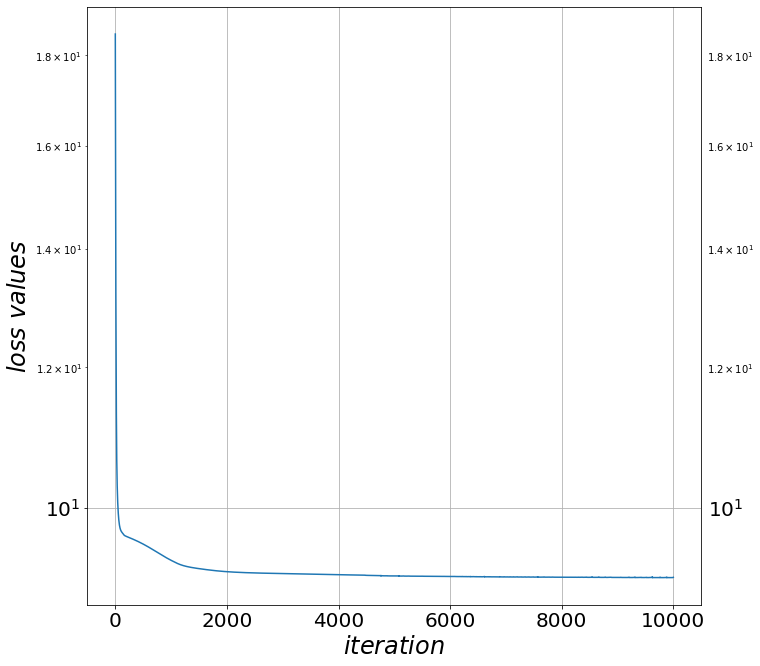

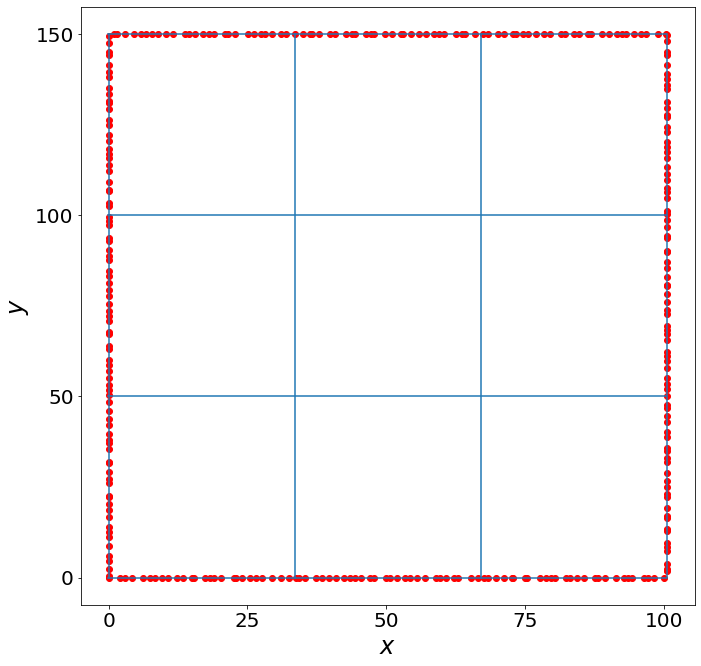

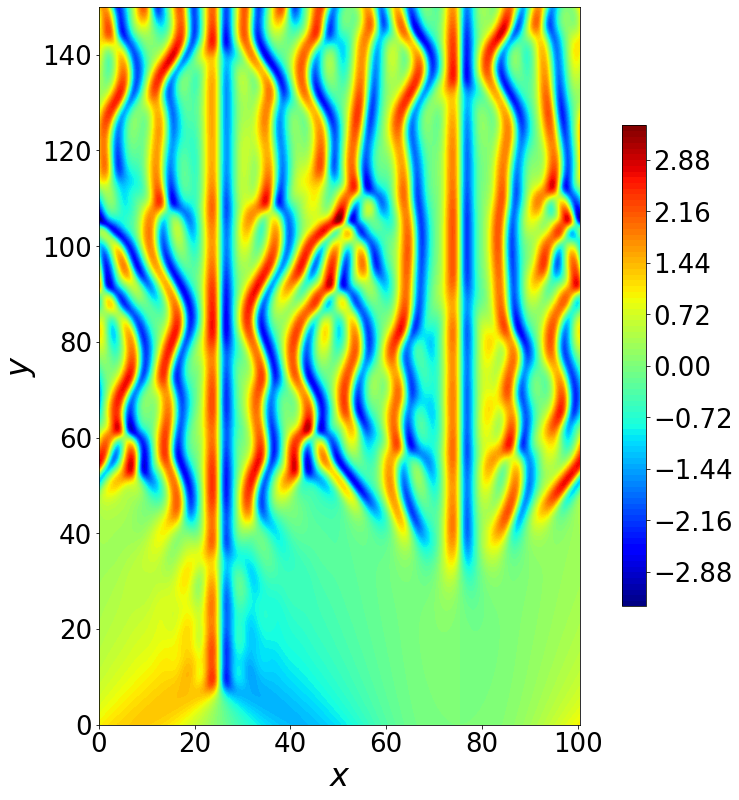

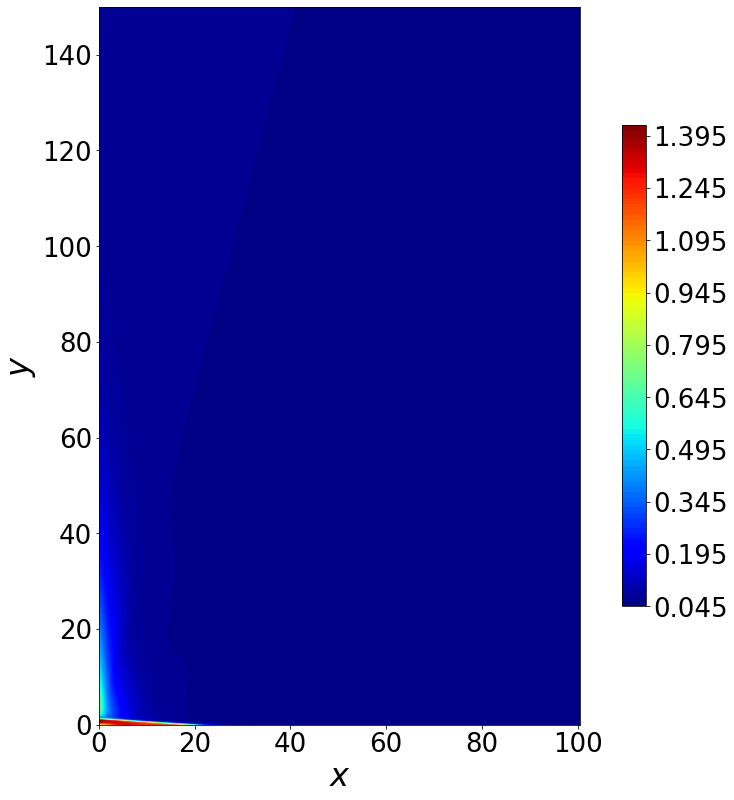

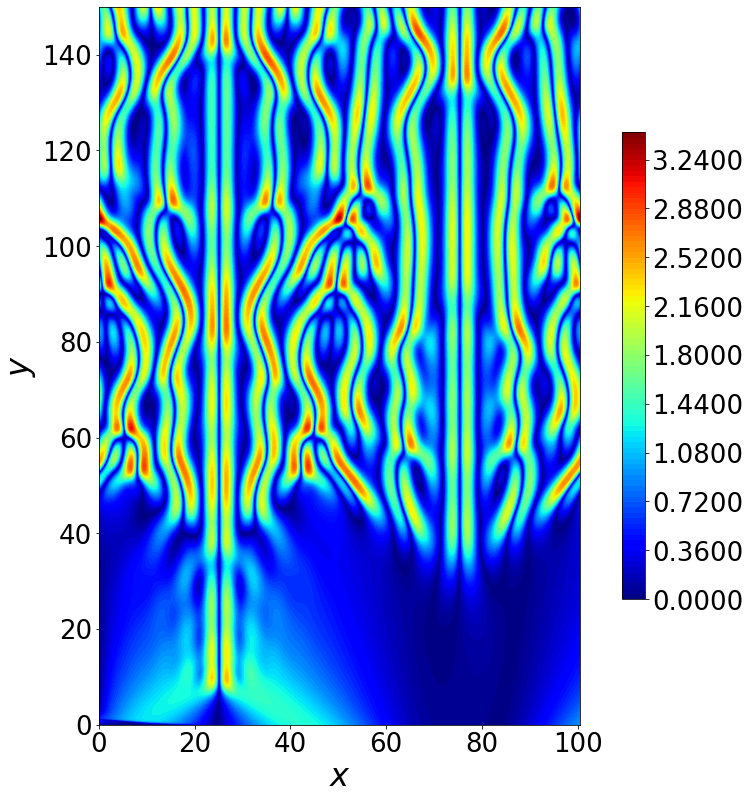

In [10]:

#                               Main
# =============================================================================    
if __name__ == "__main__":     

    '''
    Hyper-parameters: 
        scheme     = is either 'PINNs' or 'VPINNs'
        Net_layer  = the structure of fully connected network
        var_form   = the form of the variational formulation used in VPINNs
                     0, 1, 2: no, once, twice integration-by-parts
        N_el_x, N_el_y     = number of elements in x and y direction
        N_test_x, N_test_y = number of test functions in x and y direction
        N_quad     = number of quadrature points in each direction in each element
        N_bound    = number of boundary points in the boundary loss
        N_residual = number of residual points in PINNs
    '''
    scheme = 'VPINNs'
    Net_layer = [2] + [5] * 3 + [1]
    var_form  = 0
    N_el_x = 3
    N_el_y = 3
    N_test_x = N_el_x*[5]
    N_test_y = N_el_y*[5]
    N_quad = 10
    N_bound = 80
    N_residual = 100    
    
    caminho = r'/content/drive/MyDrive/Colab Notebooks/hp-vpinn/Results/'   # Directory to save figs
    problema = 'ks_3x_3t_'   # Preffix for fig anmes when saving

    # To change the problem (PDE), 5 things must be changed:
    #   1. Definition of the exact solution: function u_ext (line 53 of this cell)
    #   2. Definition of the force term fo the PDE: function f_ext (line 81 of this cell)
    #   3. Definition of the variational term for the residual calculation: variable integrand_1 (line 64 of previous cell)
    #   4. Definition of the operand of the PDE: function net_f (line 176 of previous cell)
    #   5. Definition of the training boundaries: lines 95-126 of this cell
    #   6. Domain lmits: x_l, x_r, y_l, y_u, on lines 153-154 of this cell (also check delta, so that number of points is not too much or too little)
    # The var_form variable (line 20 of this cell) is supposed to be 0, for any problem other than Poisson 2D

    ###########################################################################
    def Test_fcn_x(n,x):
       test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
       return test
    def Test_fcn_y(n,y):
       test  = Jacobi(n+1,0,0,y) - Jacobi(n-1,0,0,y)
       return test

    ###########################################################################    
    # omegax = 2*np.pi
    # omegay = 2*np.pi
    # r1 = 10
    def u_ext(x, y):
        # utemp = (0.1*np.sin(omegax*x) + np.tanh(r1*x)) * np.sin(omegay*(y))   # Example 5.2
        # utemp = 2*(1+y)/((3+x)**2 +(1+y)**2)   # Example 5.1
        
        # Burgers --------------------------------------------------------------
        M_burgers = 5
        # Concave
        # aux = x/(y + 1e-6*(y==0)) + 1e-6*(x==0)
        # utemp = (np.sqrt(M_burgers/aux)-1)/(M_burgers-1)*(aux<=M_burgers)*(aux>=1/M_burgers) + 1*(aux<1/M_burgers)
        # Convex
        # utemp = 1*(x<=y)
        # Non-convex
        # utemp = u_an(x, y, 'ncvx1')

        # Kuramoto-Sivashinsky -------------------------------------------------
        try:
          iter_tester = iter(y)
          utemp = []
          for i in range(len(y)):
            # utemp.append(ks_interp(x[i]*32*np.pi, y[i]*150))
            utemp.append(ks_interp(x[i], y[i]))
        except TypeError as te:
          # utemp = ks_interp(x*32*np.pi, y*150)
          utemp = ks_interp(x, y)


        return utemp

    def f_ext(x,y):
        # gtemp = (-0.1*(omegax**2)*np.sin(omegax*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2))*np.sin(omegay*(y))\
        #         +(0.1*np.sin(omegax*x) + np.tanh(r1*x)) * (-omegay**2 * np.sin(omegay*(y)))   # Example 5.2

        # gtemp1 = 2*(y+1)*((8*(x+3)**2)/((x+3)**2+(y+1)**2)**3 - 2/((x + 3)**2 + (y + 1)**2)**2)
        # gtemp2 = (4*(y + 1)*(-3*x*(x + 6) + y*(y + 2) - 26))/(x*(x + 6) + y*(y + 2) + 10)**3
        # gtemp = gtemp1 + gtemp2   # XAMPLE 5.1

        # Burgers and KS --------------------------------------------------------------
        gtemp = 0

        return gtemp
    
    ###########################################################################
    # Boundary points
    x_up = 32*np.pi*lhs(1,N_bound)
    y_up = np.empty(len(x_up))[:,None]
    y_up.fill(150)
    b_up = np.empty(len(x_up))[:,None]
    b_up = u_ext(x_up, y_up)
    x_up_train = np.hstack((x_up, y_up))
    u_up_train = b_up

    x_lo = 32*np.pi*lhs(1,N_bound)
    y_lo = np.empty(len(x_lo))[:,None]
    y_lo.fill(0)
    b_lo = np.empty(len(x_lo))[:,None]
    b_lo = u_ext(x_lo, y_lo)
    x_lo_train = np.hstack((x_lo, y_lo))
    u_lo_train = b_lo

    y_ri = 150*lhs(1,N_bound)
    x_ri = np.empty(len(y_ri))[:,None]
    x_ri.fill(32*np.pi)
    b_ri = np.empty(len(y_ri))[:,None]
    b_ri = u_ext(x_ri, y_ri)
    x_ri_train = np.hstack((x_ri, y_ri))
    u_ri_train = b_ri    

    y_le = 150*lhs(1,N_bound)
    x_le = np.empty(len(y_le))[:,None]
    x_le.fill(0)
    b_le = np.empty(len(y_le))[:,None]
    b_le = u_ext(x_le, y_le)
    x_le_train = np.hstack((x_le, y_le))
    u_le_train = b_le    

    # Training bounds ----------------------------------------------------------
    X_u_train = np.concatenate((x_up_train, x_lo_train, x_ri_train, x_le_train))
    u_train = np.concatenate((u_up_train, u_lo_train, u_ri_train, u_le_train))

    ###########################################################################
    # Residual points for PINNs
    grid_pt = lhs(2,N_residual)
    xf = grid_pt[:,0]
    yf = grid_pt[:,1]
    ff = np.asarray([ f_ext(xf[j],yf[j]) for j in range(len(yf))])
    X_f_train = np.hstack((xf[:,None],yf[:,None]))
    f_train = ff[:,None]

    ###########################################################################
    # Quadrature points
    [X_quad, WX_quad] = GaussLobattoJacobiWeights(N_quad, 0, 0)
    Y_quad, WY_quad   = (X_quad, WX_quad)
    xx, yy            = np.meshgrid(X_quad,  Y_quad)
    wxx, wyy          = np.meshgrid(WX_quad, WY_quad)
    XY_quad_train     = np.hstack((xx.flatten()[:,None],  yy.flatten()[:,None]))
    WXY_quad_train    = np.hstack((wxx.flatten()[:,None], wyy.flatten()[:,None]))

    ###########################################################################
    # Construction of RHS for VPINNs
    NE_x, NE_y = N_el_x, N_el_y
    [x_l, x_r] = [0, 32*np.pi]
    [y_l, y_u] = [0, 150]
    delta_x    = (x_r - x_l)/NE_x
    delta_y    = (y_u - y_l)/NE_y
    grid_x     = np.asarray([ x_l + i*delta_x for i in range(NE_x+1)])
    grid_y     = np.asarray([ y_l + i*delta_y for i in range(NE_y+1)])

#    N_testfcn_total = [(len(grid_x)-1)*[N_test_x], (len(grid_y)-1)*[N_test_y]]
    N_testfcn_total = [N_test_x, N_test_y]
 
    #+++++++++++++++++++
    x_quad  = XY_quad_train[:,0:1]
    y_quad  = XY_quad_train[:,1:2]
    w_quad  = WXY_quad_train
    U_ext_total = []
    F_ext_total = []
    for ex in range(NE_x):
        for ey in range(NE_y):
            Ntest_elementx  = N_testfcn_total[0][ex]
            Ntest_elementy  = N_testfcn_total[1][ey]
            
            x_quad_element = grid_x[ex] + (grid_x[ex+1]-grid_x[ex])/2*(x_quad+1)
            y_quad_element = grid_y[ey] + (grid_y[ey+1]-grid_y[ey])/2*(y_quad+1)
            jacobian       = ((grid_x[ex+1]-grid_x[ex])/2)*((grid_y[ey+1]-grid_y[ey])/2)
            
            testx_quad_element = np.asarray([ Test_fcn_x(n,x_quad)  for n in range(1, Ntest_elementx+1)])
            testy_quad_element = np.asarray([ Test_fcn_y(n,y_quad)  for n in range(1, Ntest_elementy+1)])
    
            u_quad_element = u_ext(x_quad_element, y_quad_element)
            f_quad_element = f_ext(x_quad_element, y_quad_element)
            
            U_ext_element = np.asarray([[jacobian*np.sum(\
                            w_quad[:,0:1]*testx_quad_element[r]*w_quad[:,1:2]*testy_quad_element[k]*u_quad_element) \
                            for r in range(Ntest_elementx)] for k in range(Ntest_elementy)])
    
            F_ext_element = np.asarray([[jacobian*np.sum(\
                            w_quad[:,0:1]*testx_quad_element[r]*w_quad[:,1:2]*testy_quad_element[k]*f_quad_element) \
                            for r in range(Ntest_elementx)] for k in range(Ntest_elementy)])
            
            U_ext_total.append(U_ext_element)
    
            F_ext_total.append(F_ext_element)
    
#    U_ext_total = np.reshape(U_ext_total, [NE_x, NE_y, N_test_y, N_test_x])
    F_ext_total = np.reshape(F_ext_total, [NE_x, NE_y, N_test_y[0], N_test_x[0]])
    
    ###########################################################################
    # Test points
    delta_test = 0.1
    xtest = np.arange(x_l, x_r + delta_test, delta_test)
    ytest = np.arange(y_l, y_u + delta_test, delta_test)
    # data_temp = np.asarray([[ [xtest[i],ytest[j],u_ext(xtest[i],ytest[j])] for i in range(len(xtest))] for j in range(len(ytest))])
    data_temp = np.array([[[xaux, yaux, u_ext(xaux, yaux)] for xaux in xtest] for yaux in ytest])
    Xtest = data_temp.flatten()[0::3]
    Ytest = data_temp.flatten()[1::3]
    Exact = data_temp.flatten()[2::3]
    X_test = np.hstack((Xtest[:,None],Ytest[:,None]))
    u_test = Exact[:,None]


    ###########################################################################
    model = VPINN(X_u_train, u_train, X_f_train, f_train, XY_quad_train, WXY_quad_train,\
                  U_ext_total, F_ext_total, grid_x, grid_y, N_testfcn_total, X_test, u_test, Net_layer)
    
    u_pred_his, loss_his = [], []
    model.train(10000 + 1)
    u_pred = model.predict()

    ###########################################################################
    # =============================================================================
    #    Plotting
    # =============================================================================
    fontsize = 24
    fig = plt.figure(1)
    plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
    plt.xlabel('$iteration$', fontsize = fontsize)
    plt.ylabel('$loss \,\, values$', fontsize = fontsize)
    plt.yscale('log')
    plt.grid(True)
    plt.plot(loss_his)
    plt.tick_params( labelsize = 20)
    #fig.tight_layout()
    fig.set_size_inches(w=11,h=11)
    plt.savefig(''.join([caminho,problema,scheme,'_loss','.png']))
    
    ###########################################################################
    x_train_plot, y_train_plot = zip(*X_u_train)
    x_f_plot, y_f_plot = zip(*X_f_train)
    fig, ax = plt.subplots(1)
    if scheme == 'VPINNs':
        plt.scatter(x_train_plot, y_train_plot, color='red')
        for xc in grid_x:
            plt.axvline(x=xc, ymin=0.045, ymax=0.954, linewidth=1.5)
        for yc in grid_y:
            plt.axhline(y=yc, xmin=0.045, xmax=0.954, linewidth=1.5)
    if scheme == 'PINNs':
        plt.scatter(x_train_plot, y_train_plot, color='red')
        plt.scatter(x_f_plot,y_f_plot)
        plt.axhline(-1, linewidth=1, linestyle='--', color='k')
        plt.axhline(1, linewidth=1, linestyle='--', color='k')
        plt.axvline(-1, linewidth=1, linestyle='--', color='k')
        plt.axvline(1, linewidth=1, linestyle='--', color='k')
    # plt.xlim([-1.1,1.1])
    # plt.ylim([-1.1,1.1])
    plt.xlabel('$x$', fontsize = fontsize)
    plt.ylabel('$y$', fontsize = fontsize)
    #ax.set_aspect(1)
    ax.locator_params(nbins=5)
    plt.tick_params( labelsize = 20)
    #fig.tight_layout()
    fig.set_size_inches(w=11,h=11)
    plt.savefig(''.join([caminho,problema,scheme,'_Domain','.png']))
    
    ###########################################################################
    x_test_plot = np.asarray(np.split(X_test[:,0:1].flatten(),len(ytest)))
    y_test_plot = np.asarray(np.split(X_test[:,1:2].flatten(),len(ytest)))
    u_test_plot = np.asarray(np.split(u_test.flatten(),len(ytest)))
    u_pred_plot = np.asarray(np.split(u_pred.flatten(),len(ytest)))
    
    
    fontsize = 32
    labelsize = 26
    fig_ext, ax_ext = plt.subplots(constrained_layout=True)
    CS_ext = ax_ext.contourf(x_test_plot, y_test_plot, u_test_plot, 100, cmap='jet', origin='lower')
    cbar = fig_ext.colorbar(CS_ext, shrink=0.67)
    cbar.ax.tick_params(labelsize = labelsize)
    ax_ext.locator_params(nbins=8)
    ax_ext.set_xlabel('$x$' , fontsize = fontsize)
    ax_ext.set_ylabel('$y$' , fontsize = fontsize)
    plt.tick_params( labelsize = labelsize)
    ax_ext.set_aspect(1)
    #fig.tight_layout()
    fig_ext.set_size_inches(w=11,h=11)
    plt.savefig(''.join([caminho,problema,scheme,'_Exact','.png']))
    
    
    
    fig_pred, ax_pred = plt.subplots(constrained_layout=True)
    CS_pred = ax_pred.contourf(x_test_plot, y_test_plot, u_pred_plot, 100, cmap='jet', origin='lower')
    cbar = fig_pred.colorbar(CS_pred, shrink=0.67)
    cbar.ax.tick_params(labelsize = labelsize)
    ax_pred.locator_params(nbins=8)
    ax_pred.set_xlabel('$x$' , fontsize = fontsize)
    ax_pred.set_ylabel('$y$' , fontsize = fontsize)
    plt.tick_params( labelsize = labelsize)
    ax_pred.set_aspect(1)
    #fig.tight_layout()
    fig_pred.set_size_inches(w=11,h=11)
    plt.savefig(''.join([caminho,problema,scheme,'_Predict','.png']))
    
    
    
    fig_err, ax_err = plt.subplots(constrained_layout=True)
    CS_err = ax_err.contourf(x_test_plot, y_test_plot, abs(u_test_plot - u_pred_plot), 100, cmap='jet', origin='lower')
    cbar = fig_err.colorbar(CS_err, shrink=0.65, format="%.4f")
    cbar.ax.tick_params(labelsize = labelsize)
    ax_err.locator_params(nbins=8)
    ax_err.set_xlabel('$x$' , fontsize = fontsize)
    ax_err.set_ylabel('$y$' , fontsize = fontsize)
    plt.tick_params( labelsize = labelsize)
    ax_err.set_aspect(1)
    #fig.tight_layout()
    fig_err.set_size_inches(w=11,h=11)
    plt.savefig(''.join([caminho,problema,scheme,'_PntErr','.png']))
    

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
